In [1]:
# prompt: import task2 excel file from this drive folder as df in colab google drive

import pandas as pd
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [6]:

# Replace 'your_folder_path' and 'your_excel_file.xlsx' with your actual paths
file_path = '/content/drive/MyDrive/Test 1/task2.xlsx'

try:
  df = pd.read_excel(file_path)
  print("Successfully imported Excel file as DataFrame.")
except FileNotFoundError:
  print(f"Error: File not found at {file_path}. Please check the file path.")
except Exception as e:
  print(f"An error occurred: {e}")


Successfully imported Excel file as DataFrame.


In [7]:
# Install if not already
# pip install nltk imbalanced-learn wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE

# Setup
nltk.download('vader_lexicon')
sns.set(style='whitegrid')


# Fill and convert text columns
df['overview'] = df['overview'].astype(str)
df['genres'] = df['genres'].fillna("Unknown")

# Sentiment Analysis using VADER
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['overview'].apply(lambda x: sia.polarity_scores(x)['compound'])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


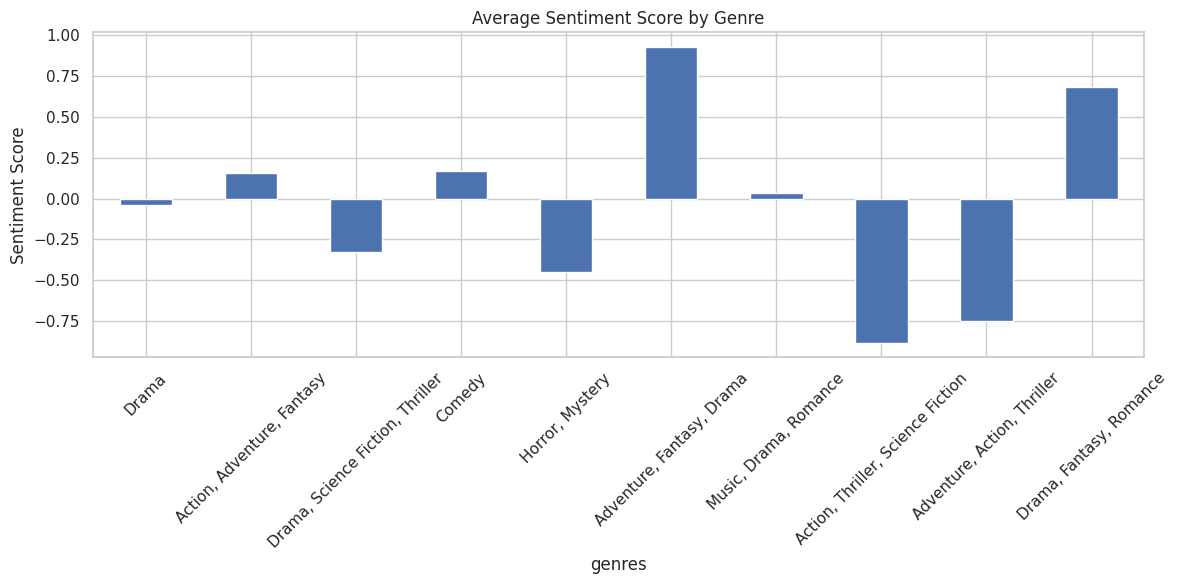

In [8]:

# ---------------------------------------------------
# Task 1: Sentiment & Engagement by Genre
# ---------------------------------------------------
genre_sentiment = df.groupby('genres').agg({
    'sentiment_score': 'mean',
    'vote_average': 'mean',
    'vote_count': 'sum'
}).sort_values(by='vote_count', ascending=False)

# Plot top 10 genres by sentiment
plt.figure(figsize=(12,6))
genre_sentiment['sentiment_score'].head(10).plot(kind='bar', title='Average Sentiment Score by Genre')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


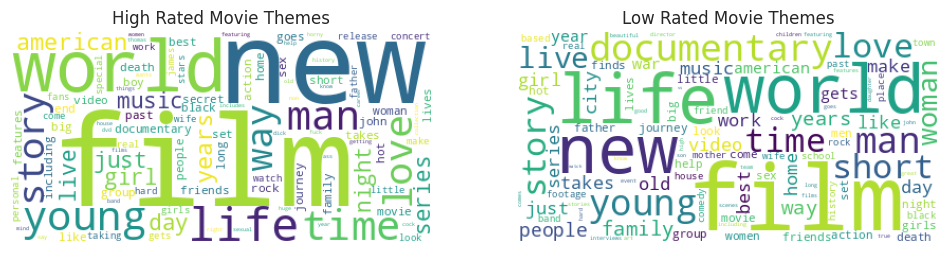

In [9]:

# ---------------------------------------------------
# Task 2: Topic Modeling (TF-IDF) for High vs Low Rated
# ---------------------------------------------------
high_rated = df[df['vote_average'] >= 9]
low_rated = df[df['vote_average'] <= 3]

# TF-IDF setup
tfidf = TfidfVectorizer(stop_words='english', max_features=100)

# High rated
high_words = tfidf.fit_transform(high_rated['overview'])
high_vocab = tfidf.get_feature_names_out()
high_sum = high_words.sum(axis=0).A1
high_freq = dict(zip(high_vocab, high_sum))

# Low rated
low_words = tfidf.fit_transform(low_rated['overview'])
low_vocab = tfidf.get_feature_names_out()
low_sum = low_words.sum(axis=0).A1
low_freq = dict(zip(low_vocab, low_sum))

# WordClouds
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(background_color='white').generate_from_frequencies(high_freq))
plt.axis('off')
plt.title("High Rated Movie Themes")

plt.subplot(1,2,2)
plt.imshow(WordCloud(background_color='white').generate_from_frequencies(low_freq))
plt.axis('off')
plt.title("Low Rated Movie Themes")
plt.show()


In [10]:

# ---------------------------------------------------
# Task 3: Predicting Movie Popularity
# ---------------------------------------------------

# Binary label: 1 if vote_average >= 7
df['popular'] = np.where(df['vote_average'] >= 7, 1, 0)

# TF-IDF for text feature
tfidf_vec = TfidfVectorizer(max_features=300, stop_words='english')
X_tfidf = tfidf_vec.fit_transform(df['overview'])

# Combine TF-IDF with sentiment score
X = np.hstack((X_tfidf.toarray(), df[['sentiment_score']].values))
y = df['popular']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# SMOTE Oversampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Random Forest with class weights
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train_res, y_train_res)

# Prediction & Evaluation
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("✅ Classification Report:\n", classification_report(y_test, y_pred))
print("✅ ROC AUC Score:", roc_auc_score(y_test, y_proba))


✅ Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      2563
           1       0.20      0.11      0.14       437

    accuracy                           0.81      3000
   macro avg       0.53      0.52      0.52      3000
weighted avg       0.76      0.81      0.78      3000

✅ ROC AUC Score: 0.5336758536147661
